# Detecting Deep Fake Images

In [1]:
import torch
import numpy as np
from torch import nn
import torchvision
from torch.utils.data import DataLoader, ConcatDataset, Subset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchinfo import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from torch.optim import Adadelta
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import seaborn as sns
import os
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
cuda_bin_path = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.2\bin"
os.add_dll_directory(cuda_bin_path)
from thundersvm import SVC
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [2]:
def seed_everything(seed=1):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed = 1
seed_everything(seed)

img_size = 50

train_dir = 'archive/Processed/Train/'
validation_dir = 'archive/Processed/Validation/'
test_dir = 'archive/Processed/Test/'

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
])

# Load data
train_dataset = ImageFolder(root=train_dir, transform=transform)
validation_dataset = ImageFolder(root=validation_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

batch_size = 15
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)  
valid_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=4)  
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Training Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(validation_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

Training Dataset Size: 140002
Validation Dataset Size: 39428
Test Dataset Size: 10905


In [3]:
def print_class_counts(dataset, name):
    if hasattr(dataset, 'targets'):
        counts = Counter(dataset.targets)
        print(f"{name} Dataset: 'Fake' class count = {counts[0]}, 'Real' class count = {counts[1]}")

print_class_counts(train_dataset, "Training")
print_class_counts(validation_dataset, "Validation")
print_class_counts(test_dataset, "Test")

Training Dataset: 'Fake' class count = 70001, 'Real' class count = 70001
Validation Dataset: 'Fake' class count = 19641, 'Real' class count = 19787
Test Dataset: 'Fake' class count = 5492, 'Real' class count = 5413


In [4]:
def imshow(img, nrow=8):
    npimg = img.numpy()
    fig_width = nrow * 2  
    plt.figure(figsize=(fig_width, fig_width // 2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off') 
    plt.show()

def display_images_by_class(loader, class_name='Real', num_imgs=16):
    """Display a grid of images belonging to a specified class."""
    class_label = 1 if class_name == 'Real' else 0

    images_to_display = []
    labels_to_display = []

    for images, labels in loader:
        mask = labels == class_label
        filtered_images = images[mask]
        filtered_labels = labels[mask]

        images_to_display.extend(filtered_images)
        labels_to_display.extend(filtered_labels)

        if len(images_to_display) >= num_imgs:
            break

    images_to_display = images_to_display[:num_imgs]

    imshow(torchvision.utils.make_grid(images_to_display, nrow=12))  

# Real Images

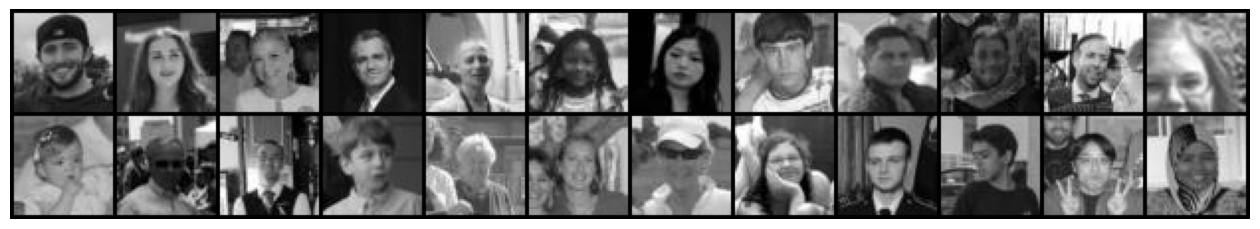

In [5]:
display_images_by_class(train_loader, class_name='Real', num_imgs=24)

# Deep Fakes

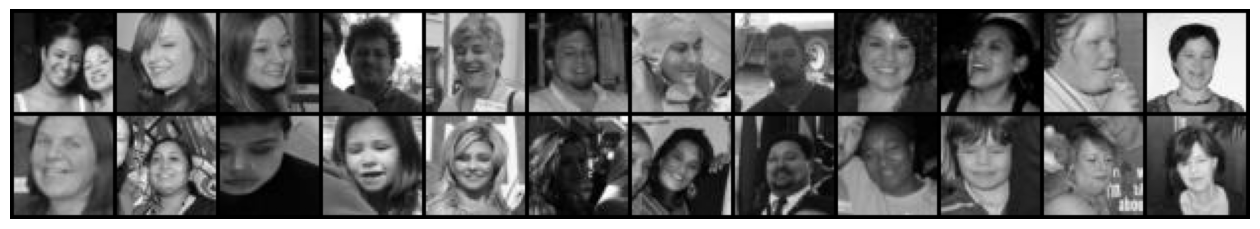

In [6]:
display_images_by_class(train_loader, class_name='Fake', num_imgs=24)

# Neural Network

In [26]:
class ConvModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(ConvModel, self).__init__()
        self.main = nn.Sequential(

            nn.Conv2d(input_size, 64, kernel_size=3, padding='same'), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding='same'), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(256, 256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(256, 256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            
            nn.AdaptiveAvgPool2d((1, 1)),
            
            nn.Flatten(),
            
            nn.Linear(256, output_size)
        )

    def forward(self, x):
        x = self.main(x)
        return torch.sigmoid(x)

In [27]:
model_display = ConvModel(1, 1)
model_summary = summary(model_display, input_size=(1, 1, img_size, img_size))
model_summary

Layer (type:depth-idx)                   Output Shape              Param #
ConvModel                                [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Conv2d: 2-1                       [1, 64, 50, 50]           640
│    └─BatchNorm2d: 2-2                  [1, 64, 50, 50]           128
│    └─ReLU: 2-3                         [1, 64, 50, 50]           --
│    └─Conv2d: 2-4                       [1, 128, 50, 50]          73,856
│    └─BatchNorm2d: 2-5                  [1, 128, 50, 50]          256
│    └─ReLU: 2-6                         [1, 128, 50, 50]          --
│    └─MaxPool2d: 2-7                    [1, 128, 25, 25]          --
│    └─Conv2d: 2-8                       [1, 256, 25, 25]          295,168
│    └─BatchNorm2d: 2-9                  [1, 256, 25, 25]          512
│    └─ReLU: 2-10                        [1, 256, 25, 25]          --
│    └─MaxPool2d: 2-11                   [1, 256, 12, 12]          --
│ 

In [28]:
def train_step(model, train_loader, loss_fn, optimizer, reg_param, device):
    train_losses = []
    correct = 0
    total = 0
    
    for batch_idx, (input_imgs, labels) in enumerate(tqdm(train_loader)):
        input_imgs, labels = input_imgs.to(device), labels.to(device).float()
        input_imgs = transform_aug(input_imgs)
        optimizer.zero_grad()
        output = model(input_imgs).squeeze(1)
    
        loss = loss_fn(output, labels)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        predicted = (output > 0.5).float()  # Apply threshold to get predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    avg_loss = sum(train_losses) / len(train_losses)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [29]:
def evaluation_step(model, data_loader, loss_fn, reg_param, device):
    with torch.no_grad():
        total = 0
        correct = 0 
        total_loss = 0
        for batch_idx, (input_imgs, labels) in enumerate(data_loader):
            input_imgs, labels = input_imgs.to(device), labels.to(device).float()
            
            output = model(input_imgs).squeeze(1)
            eval_loss = loss_fn(output, labels)
            total_loss += eval_loss.item() * input_imgs.shape[0]
            
            predicted = (output > 0.5).float()  # Apply threshold to get predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        final_loss = total_loss / total
        final_acc = 100 * correct / total
        
        return final_loss, final_acc

### Image Augmentation To Prevent Overfitting

In [30]:
transform_aug = transforms.Compose([
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.08), ratio=(0.3, 3.3), value='random'),
    transforms.RandomApply([
        transforms.Compose([
            transforms.ColorJitter(brightness=0.05, contrast=0.05),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=(-5, 5), translate=(0.05, 0.05)),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))], p=0.8),
            transforms.RandomResizedCrop(size=(img_size, img_size), scale=(0.8, 1.0), ratio=(0.75, 1.33)),
        ])
    ], p=0.9),
])

def image_aug(input_imgs):
    return transform_aug(input_imgs)

In [39]:
def train_conv_model(train_loader, valid_loader, test_loader, random_seed):
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    else:
        if torch.backends.mps.is_available():
            device = "mps"

    torch.manual_seed(random_seed) 
    
    epochs = 20
    reg_param =0 
    model = ConvModel(1, 1).to(device)
    loss_function = nn.BCELoss()
    
    optimizer = optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=reg_param)
    
    train_schedule = [15] 
    scheduler = MultiStepLR(optimizer, milestones=train_schedule, gamma=0.5)
    
    train_losses = []
    val_losses = []
    test_losses = []
    
    train_accs = []
    val_accs = []
    test_accs = []
    
    for epoch in range(epochs):
        # Training pass
        train_loss, train_acc = train_step(model, train_loader, loss_function, optimizer, reg_param, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        val_loss, val_acc = evaluation_step(model, valid_loader, loss_function, reg_param, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Test
        test_loss, test_acc = evaluation_step(model, test_loader, loss_function, reg_param, device)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        epoch_width = len(str(epoch+1))
        print(f"Epoch: {epoch+1:<{epoch_width}} | Train Acc: {train_acc:.2f}    Val Acc: {val_acc:.2f}    Test Acc: {test_acc:.2f}\n{' '*(8+epoch_width)}| Train Loss: {train_loss:.2f}    Val Loss: {val_loss:.2f}    Test Loss: {test_loss:.2f}")

        scheduler.step()
    return model, train_losses, train_accs, val_losses, val_accs, test_losses, test_accs

In [40]:
def get_predictions_and_labels(model, loader, device="cuda"):
    model.eval()  
    predictions = []
    labels = []
    
    with torch.no_grad():  
        for inputs, true_labels in loader:
            inputs = inputs.to(device)
            true_labels = true_labels.to(device)
            
            outputs = model(inputs)
            predicted_labels = outputs.round() 
            
            predictions.extend(predicted_labels.cpu().numpy())
            labels.extend(true_labels.cpu().numpy())
    
    return np.array(predictions), np.array(labels)

### Random Seeds For Replication

In [37]:
seeds = (np.random.rand(1, 5)*100).astype(int).squeeze()
seeds

array([41, 68, 20, 87,  2])

In [41]:
global_train_losses = []
global_train_accuracies = []
global_valid_losses = []
global_valid_accuracies = []
global_test_losses = []
global_test_accuracies = []
confusion_list = []

for sd in range(len(seeds)):
    model, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies\
    = train_conv_model(train_loader, valid_loader, test_loader, sd)
    global_train_losses.append(train_losses)
    global_train_accuracies.append(train_accuracies)
    global_valid_losses.append(valid_losses)
    global_valid_accuracies.append(valid_accuracies)
    global_test_losses.append(test_losses)
    global_test_accuracies.append(test_accuracies)
    confusion_list.append(get_predictions_and_labels(model, test_loader, "cuda"))
    model = 0

100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 211.97it/s]


Epoch: 1 | Train Acc: 77.72    Val Acc: 85.60    Test Acc: 67.85
         | Train Loss: 0.45    Val Loss: 0.32    Test Loss: 0.70


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 209.00it/s]


Epoch: 2 | Train Acc: 85.65    Val Acc: 82.25    Test Acc: 67.69
         | Train Loss: 0.32    Val Loss: 0.39    Test Loss: 0.76


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 206.51it/s]


Epoch: 3 | Train Acc: 87.75    Val Acc: 90.77    Test Acc: 78.15
         | Train Loss: 0.28    Val Loss: 0.22    Test Loss: 0.49


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 208.62it/s]


Epoch: 4 | Train Acc: 88.81    Val Acc: 91.09    Test Acc: 79.11
         | Train Loss: 0.26    Val Loss: 0.22    Test Loss: 0.50


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 206.07it/s]


Epoch: 5 | Train Acc: 89.44    Val Acc: 91.14    Test Acc: 80.79
         | Train Loss: 0.25    Val Loss: 0.21    Test Loss: 0.45


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 207.94it/s]


Epoch: 6 | Train Acc: 90.02    Val Acc: 91.59    Test Acc: 82.18
         | Train Loss: 0.24    Val Loss: 0.20    Test Loss: 0.43


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 208.69it/s]


Epoch: 7 | Train Acc: 90.42    Val Acc: 91.75    Test Acc: 83.50
         | Train Loss: 0.23    Val Loss: 0.20    Test Loss: 0.41


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 208.17it/s]


Epoch: 8 | Train Acc: 90.80    Val Acc: 91.83    Test Acc: 82.05
         | Train Loss: 0.22    Val Loss: 0.19    Test Loss: 0.43


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 208.42it/s]


Epoch: 9 | Train Acc: 91.15    Val Acc: 92.68    Test Acc: 85.53
         | Train Loss: 0.21    Val Loss: 0.18    Test Loss: 0.35


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 212.11it/s]


Epoch: 10 | Train Acc: 91.35    Val Acc: 90.48    Test Acc: 82.62
          | Train Loss: 0.21    Val Loss: 0.22    Test Loss: 0.42


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 206.13it/s]


Epoch: 11 | Train Acc: 91.62    Val Acc: 92.60    Test Acc: 85.90
          | Train Loss: 0.20    Val Loss: 0.18    Test Loss: 0.35


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 210.53it/s]


Epoch: 12 | Train Acc: 91.81    Val Acc: 91.94    Test Acc: 84.98
          | Train Loss: 0.20    Val Loss: 0.19    Test Loss: 0.37


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 205.93it/s]


Epoch: 13 | Train Acc: 91.87    Val Acc: 93.17    Test Acc: 86.45
          | Train Loss: 0.20    Val Loss: 0.17    Test Loss: 0.33


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 207.72it/s]


Epoch: 14 | Train Acc: 92.16    Val Acc: 93.35    Test Acc: 88.23
          | Train Loss: 0.19    Val Loss: 0.16    Test Loss: 0.28


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 211.25it/s]


Epoch: 15 | Train Acc: 92.23    Val Acc: 93.20    Test Acc: 86.41
          | Train Loss: 0.19    Val Loss: 0.17    Test Loss: 0.34


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 210.35it/s]


Epoch: 16 | Train Acc: 93.02    Val Acc: 93.96    Test Acc: 88.48
          | Train Loss: 0.17    Val Loss: 0.15    Test Loss: 0.28


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 209.40it/s]


Epoch: 17 | Train Acc: 93.36    Val Acc: 93.64    Test Acc: 88.23
          | Train Loss: 0.16    Val Loss: 0.16    Test Loss: 0.29


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:43<00:00, 213.20it/s]


Epoch: 18 | Train Acc: 93.27    Val Acc: 94.15    Test Acc: 88.59
          | Train Loss: 0.16    Val Loss: 0.15    Test Loss: 0.27


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 209.14it/s]


Epoch: 19 | Train Acc: 93.49    Val Acc: 94.13    Test Acc: 89.04
          | Train Loss: 0.16    Val Loss: 0.15    Test Loss: 0.27


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 208.55it/s]


Epoch: 20 | Train Acc: 93.40    Val Acc: 94.42    Test Acc: 89.78
          | Train Loss: 0.16    Val Loss: 0.14    Test Loss: 0.25


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 203.71it/s]


Epoch: 1 | Train Acc: 78.36    Val Acc: 87.25    Test Acc: 67.16
         | Train Loss: 0.44    Val Loss: 0.29    Test Loss: 0.73


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 207.03it/s]


Epoch: 2 | Train Acc: 85.83    Val Acc: 89.11    Test Acc: 72.73
         | Train Loss: 0.32    Val Loss: 0.26    Test Loss: 0.64


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:43<00:00, 214.18it/s]


Epoch: 3 | Train Acc: 87.90    Val Acc: 90.46    Test Acc: 77.87
         | Train Loss: 0.28    Val Loss: 0.22    Test Loss: 0.51


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 211.22it/s]


Epoch: 4 | Train Acc: 88.93    Val Acc: 90.94    Test Acc: 80.43
         | Train Loss: 0.26    Val Loss: 0.22    Test Loss: 0.45


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:43<00:00, 214.34it/s]


Epoch: 5 | Train Acc: 89.64    Val Acc: 90.21    Test Acc: 79.87
         | Train Loss: 0.24    Val Loss: 0.23    Test Loss: 0.50


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 208.26it/s]


Epoch: 6 | Train Acc: 90.29    Val Acc: 91.73    Test Acc: 81.48
         | Train Loss: 0.23    Val Loss: 0.20    Test Loss: 0.43


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:43<00:00, 212.16it/s]


Epoch: 7 | Train Acc: 90.60    Val Acc: 91.17    Test Acc: 83.02
         | Train Loss: 0.22    Val Loss: 0.21    Test Loss: 0.41


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 209.67it/s]


Epoch: 8 | Train Acc: 90.95    Val Acc: 91.73    Test Acc: 83.07
         | Train Loss: 0.22    Val Loss: 0.20    Test Loss: 0.40


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:43<00:00, 212.69it/s]


Epoch: 9 | Train Acc: 91.09    Val Acc: 92.04    Test Acc: 84.28
         | Train Loss: 0.21    Val Loss: 0.19    Test Loss: 0.38


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 207.85it/s]


Epoch: 10 | Train Acc: 91.31    Val Acc: 92.77    Test Acc: 85.70
          | Train Loss: 0.21    Val Loss: 0.17    Test Loss: 0.35


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:43<00:00, 213.45it/s]


Epoch: 11 | Train Acc: 91.62    Val Acc: 91.51    Test Acc: 84.40
          | Train Loss: 0.20    Val Loss: 0.20    Test Loss: 0.38


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 209.84it/s]


Epoch: 12 | Train Acc: 91.87    Val Acc: 91.73    Test Acc: 84.89
          | Train Loss: 0.20    Val Loss: 0.20    Test Loss: 0.38


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 210.23it/s]


Epoch: 13 | Train Acc: 92.08    Val Acc: 93.42    Test Acc: 86.55
          | Train Loss: 0.19    Val Loss: 0.16    Test Loss: 0.32


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 211.01it/s]


Epoch: 14 | Train Acc: 92.20    Val Acc: 92.78    Test Acc: 85.45
          | Train Loss: 0.19    Val Loss: 0.18    Test Loss: 0.37


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 207.82it/s]


Epoch: 15 | Train Acc: 92.26    Val Acc: 93.90    Test Acc: 87.58
          | Train Loss: 0.19    Val Loss: 0.15    Test Loss: 0.30


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:43<00:00, 212.80it/s]


Epoch: 16 | Train Acc: 93.08    Val Acc: 93.74    Test Acc: 88.47
          | Train Loss: 0.17    Val Loss: 0.15    Test Loss: 0.29


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 207.58it/s]


Epoch: 17 | Train Acc: 93.31    Val Acc: 93.74    Test Acc: 87.84
          | Train Loss: 0.16    Val Loss: 0.16    Test Loss: 0.31


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 211.24it/s]


Epoch: 18 | Train Acc: 93.31    Val Acc: 94.11    Test Acc: 88.52
          | Train Loss: 0.16    Val Loss: 0.15    Test Loss: 0.29


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [01:27<00:00, 106.15it/s]


Epoch: 19 | Train Acc: 93.37    Val Acc: 92.84    Test Acc: 87.82
          | Train Loss: 0.16    Val Loss: 0.18    Test Loss: 0.31


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 208.71it/s]


Epoch: 20 | Train Acc: 93.55    Val Acc: 93.23    Test Acc: 87.54
          | Train Loss: 0.16    Val Loss: 0.17    Test Loss: 0.32


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 209.85it/s]


Epoch: 1 | Train Acc: 77.79    Val Acc: 84.64    Test Acc: 67.21
         | Train Loss: 0.45    Val Loss: 0.34    Test Loss: 0.72


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 208.98it/s]


Epoch: 2 | Train Acc: 85.79    Val Acc: 89.34    Test Acc: 72.94
         | Train Loss: 0.32    Val Loss: 0.25    Test Loss: 0.60


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 206.26it/s]


Epoch: 3 | Train Acc: 87.78    Val Acc: 90.90    Test Acc: 77.32
         | Train Loss: 0.28    Val Loss: 0.22    Test Loss: 0.53


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 207.59it/s]


Epoch: 4 | Train Acc: 88.88    Val Acc: 91.65    Test Acc: 79.51
         | Train Loss: 0.26    Val Loss: 0.21    Test Loss: 0.47


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 204.78it/s]


Epoch: 5 | Train Acc: 89.44    Val Acc: 89.17    Test Acc: 78.84
         | Train Loss: 0.25    Val Loss: 0.26    Test Loss: 0.55


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 208.19it/s]


Epoch: 6 | Train Acc: 90.15    Val Acc: 92.19    Test Acc: 83.15
         | Train Loss: 0.23    Val Loss: 0.19    Test Loss: 0.41


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 209.53it/s]


Epoch: 7 | Train Acc: 90.58    Val Acc: 91.45    Test Acc: 81.72
         | Train Loss: 0.22    Val Loss: 0.21    Test Loss: 0.47


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 207.58it/s]


Epoch: 8 | Train Acc: 90.92    Val Acc: 92.44    Test Acc: 83.37
         | Train Loss: 0.22    Val Loss: 0.19    Test Loss: 0.41


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 209.09it/s]


Epoch: 9 | Train Acc: 91.14    Val Acc: 92.45    Test Acc: 84.00
         | Train Loss: 0.21    Val Loss: 0.18    Test Loss: 0.39


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 207.62it/s]


Epoch: 10 | Train Acc: 91.57    Val Acc: 92.56    Test Acc: 84.99
          | Train Loss: 0.20    Val Loss: 0.18    Test Loss: 0.37


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 209.21it/s]


Epoch: 11 | Train Acc: 91.65    Val Acc: 92.76    Test Acc: 85.12
          | Train Loss: 0.20    Val Loss: 0.18    Test Loss: 0.36


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 203.82it/s]


Epoch: 12 | Train Acc: 91.78    Val Acc: 92.93    Test Acc: 86.37
          | Train Loss: 0.20    Val Loss: 0.17    Test Loss: 0.34


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 209.13it/s]


Epoch: 13 | Train Acc: 91.94    Val Acc: 93.41    Test Acc: 86.09
          | Train Loss: 0.20    Val Loss: 0.16    Test Loss: 0.35


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 209.80it/s]


Epoch: 14 | Train Acc: 92.11    Val Acc: 93.24    Test Acc: 86.85
          | Train Loss: 0.19    Val Loss: 0.17    Test Loss: 0.33


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 209.26it/s]


Epoch: 15 | Train Acc: 92.24    Val Acc: 93.78    Test Acc: 87.14
          | Train Loss: 0.19    Val Loss: 0.16    Test Loss: 0.33


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 209.54it/s]


Epoch: 16 | Train Acc: 93.07    Val Acc: 94.07    Test Acc: 87.62
          | Train Loss: 0.17    Val Loss: 0.15    Test Loss: 0.30


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 209.13it/s]


Epoch: 17 | Train Acc: 93.31    Val Acc: 94.33    Test Acc: 88.66
          | Train Loss: 0.16    Val Loss: 0.14    Test Loss: 0.29


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 212.00it/s]


Epoch: 18 | Train Acc: 93.41    Val Acc: 92.99    Test Acc: 87.76
          | Train Loss: 0.16    Val Loss: 0.17    Test Loss: 0.31


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 210.05it/s]


Epoch: 19 | Train Acc: 93.41    Val Acc: 93.99    Test Acc: 88.06
          | Train Loss: 0.16    Val Loss: 0.15    Test Loss: 0.30


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 209.58it/s]


Epoch: 20 | Train Acc: 93.47    Val Acc: 93.64    Test Acc: 88.17
          | Train Loss: 0.16    Val Loss: 0.16    Test Loss: 0.29


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 205.22it/s]


Epoch: 1 | Train Acc: 77.76    Val Acc: 86.96    Test Acc: 67.66
         | Train Loss: 0.45    Val Loss: 0.30    Test Loss: 0.70


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 207.45it/s]


Epoch: 2 | Train Acc: 85.74    Val Acc: 88.63    Test Acc: 73.00
         | Train Loss: 0.32    Val Loss: 0.26    Test Loss: 0.61


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 209.30it/s]


Epoch: 3 | Train Acc: 87.75    Val Acc: 90.19    Test Acc: 77.79
         | Train Loss: 0.28    Val Loss: 0.23    Test Loss: 0.54


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 206.11it/s]


Epoch: 4 | Train Acc: 88.73    Val Acc: 89.63    Test Acc: 78.21
         | Train Loss: 0.26    Val Loss: 0.24    Test Loss: 0.51


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 205.64it/s]


Epoch: 5 | Train Acc: 89.50    Val Acc: 90.48    Test Acc: 80.90
         | Train Loss: 0.25    Val Loss: 0.23    Test Loss: 0.45


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 204.44it/s]


Epoch: 6 | Train Acc: 90.03    Val Acc: 89.06    Test Acc: 79.72
         | Train Loss: 0.24    Val Loss: 0.26    Test Loss: 0.49


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 206.58it/s]


Epoch: 7 | Train Acc: 90.46    Val Acc: 91.71    Test Acc: 82.84
         | Train Loss: 0.23    Val Loss: 0.20    Test Loss: 0.40


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 206.33it/s]


Epoch: 8 | Train Acc: 90.80    Val Acc: 91.82    Test Acc: 82.82
         | Train Loss: 0.22    Val Loss: 0.20    Test Loss: 0.43


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 208.47it/s]


Epoch: 9 | Train Acc: 91.13    Val Acc: 92.85    Test Acc: 85.03
         | Train Loss: 0.21    Val Loss: 0.18    Test Loss: 0.37


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 209.78it/s]


Epoch: 10 | Train Acc: 91.27    Val Acc: 92.50    Test Acc: 84.46
          | Train Loss: 0.21    Val Loss: 0.18    Test Loss: 0.37


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 205.64it/s]


Epoch: 11 | Train Acc: 91.65    Val Acc: 92.53    Test Acc: 85.03
          | Train Loss: 0.20    Val Loss: 0.18    Test Loss: 0.38


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 210.17it/s]


Epoch: 12 | Train Acc: 91.62    Val Acc: 92.44    Test Acc: 84.23
          | Train Loss: 0.20    Val Loss: 0.18    Test Loss: 0.39


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 206.97it/s]


Epoch: 13 | Train Acc: 91.86    Val Acc: 92.12    Test Acc: 84.52
          | Train Loss: 0.20    Val Loss: 0.19    Test Loss: 0.40


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 210.13it/s]


Epoch: 14 | Train Acc: 92.00    Val Acc: 93.64    Test Acc: 86.57
          | Train Loss: 0.19    Val Loss: 0.16    Test Loss: 0.32


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 206.90it/s]


Epoch: 15 | Train Acc: 92.25    Val Acc: 93.16    Test Acc: 86.02
          | Train Loss: 0.19    Val Loss: 0.17    Test Loss: 0.35


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 206.45it/s]


Epoch: 16 | Train Acc: 93.01    Val Acc: 93.83    Test Acc: 88.31
          | Train Loss: 0.17    Val Loss: 0.15    Test Loss: 0.29


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 207.30it/s]


Epoch: 17 | Train Acc: 93.19    Val Acc: 94.12    Test Acc: 88.54
          | Train Loss: 0.16    Val Loss: 0.15    Test Loss: 0.29


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 207.71it/s]


Epoch: 18 | Train Acc: 93.17    Val Acc: 93.61    Test Acc: 87.87
          | Train Loss: 0.17    Val Loss: 0.15    Test Loss: 0.30


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 205.39it/s]


Epoch: 19 | Train Acc: 93.38    Val Acc: 94.12    Test Acc: 88.03
          | Train Loss: 0.16    Val Loss: 0.15    Test Loss: 0.31


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 204.35it/s]


Epoch: 20 | Train Acc: 93.44    Val Acc: 94.28    Test Acc: 88.10
          | Train Loss: 0.16    Val Loss: 0.15    Test Loss: 0.29


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 205.82it/s]


Epoch: 1 | Train Acc: 77.66    Val Acc: 85.73    Test Acc: 67.68
         | Train Loss: 0.45    Val Loss: 0.32    Test Loss: 0.71


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 210.20it/s]


Epoch: 2 | Train Acc: 85.81    Val Acc: 88.08    Test Acc: 71.99
         | Train Loss: 0.32    Val Loss: 0.27    Test Loss: 0.60


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 204.85it/s]


Epoch: 3 | Train Acc: 87.76    Val Acc: 89.82    Test Acc: 74.83
         | Train Loss: 0.28    Val Loss: 0.25    Test Loss: 0.60


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 206.06it/s]


Epoch: 4 | Train Acc: 88.68    Val Acc: 89.38    Test Acc: 78.50
         | Train Loss: 0.26    Val Loss: 0.25    Test Loss: 0.51


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 204.71it/s]


Epoch: 5 | Train Acc: 89.50    Val Acc: 91.46    Test Acc: 81.18
         | Train Loss: 0.25    Val Loss: 0.21    Test Loss: 0.48


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:46<00:00, 202.45it/s]


Epoch: 6 | Train Acc: 90.19    Val Acc: 91.82    Test Acc: 82.10
         | Train Loss: 0.23    Val Loss: 0.20    Test Loss: 0.43


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 206.88it/s]


Epoch: 7 | Train Acc: 90.53    Val Acc: 92.30    Test Acc: 82.99
         | Train Loss: 0.22    Val Loss: 0.19    Test Loss: 0.42


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 207.88it/s]


Epoch: 8 | Train Acc: 90.76    Val Acc: 92.46    Test Acc: 85.13
         | Train Loss: 0.22    Val Loss: 0.18    Test Loss: 0.37


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 206.78it/s]


Epoch: 9 | Train Acc: 91.17    Val Acc: 91.94    Test Acc: 84.63
         | Train Loss: 0.21    Val Loss: 0.19    Test Loss: 0.37


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 206.99it/s]


Epoch: 10 | Train Acc: 91.48    Val Acc: 92.49    Test Acc: 85.52
          | Train Loss: 0.21    Val Loss: 0.19    Test Loss: 0.35


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 204.81it/s]


Epoch: 11 | Train Acc: 91.61    Val Acc: 92.34    Test Acc: 85.71
          | Train Loss: 0.20    Val Loss: 0.19    Test Loss: 0.35


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 207.77it/s]


Epoch: 12 | Train Acc: 91.96    Val Acc: 92.99    Test Acc: 86.29
          | Train Loss: 0.20    Val Loss: 0.17    Test Loss: 0.35


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 206.39it/s]


Epoch: 13 | Train Acc: 91.93    Val Acc: 92.24    Test Acc: 85.54
          | Train Loss: 0.19    Val Loss: 0.19    Test Loss: 0.35


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 207.91it/s]


Epoch: 14 | Train Acc: 92.26    Val Acc: 92.77    Test Acc: 85.76
          | Train Loss: 0.19    Val Loss: 0.18    Test Loss: 0.34


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:45<00:00, 206.45it/s]


Epoch: 15 | Train Acc: 92.28    Val Acc: 93.34    Test Acc: 87.08
          | Train Loss: 0.19    Val Loss: 0.17    Test Loss: 0.33


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 210.69it/s]


Epoch: 16 | Train Acc: 92.93    Val Acc: 94.04    Test Acc: 88.22
          | Train Loss: 0.17    Val Loss: 0.15    Test Loss: 0.29


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:43<00:00, 212.68it/s]


Epoch: 17 | Train Acc: 93.37    Val Acc: 93.57    Test Acc: 88.25
          | Train Loss: 0.16    Val Loss: 0.16    Test Loss: 0.29


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:43<00:00, 213.19it/s]


Epoch: 18 | Train Acc: 93.45    Val Acc: 93.19    Test Acc: 88.17
          | Train Loss: 0.16    Val Loss: 0.17    Test Loss: 0.30


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:43<00:00, 213.19it/s]


Epoch: 19 | Train Acc: 93.37    Val Acc: 94.00    Test Acc: 89.23
          | Train Loss: 0.16    Val Loss: 0.15    Test Loss: 0.27


100%|█████████████████████████████████████████████████████████████████████████████| 9334/9334 [00:44<00:00, 210.27it/s]


Epoch: 20 | Train Acc: 93.51    Val Acc: 94.00    Test Acc: 89.30
          | Train Loss: 0.16    Val Loss: 0.15    Test Loss: 0.27


In [42]:
def plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies, title):
    epochs = range(1, len(train_accuracies) + 1)
    plt.figure(figsize=(14, 4))
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, valid_accuracies, label='Valid Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)  
    plt.legend()
    plt.grid(True)
    plt.show()

In [43]:
def plot_loss_performance(train_losses, valid_losses, test_losses, title):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 4))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, valid_losses, label='Valid Loss')
    plt.plot(epochs, test_losses, label='Test Loss')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)  
    plt.legend()
    plt.grid(True)
    plt.show()

In [44]:
def average_across_seeds(accuracies):
    accuracies_array = np.array(accuracies)
    average_accuracies = np.mean(accuracies_array, axis=0)
    return average_accuracies.tolist()

cumulative_train_losses = average_across_seeds(global_train_losses)
cumulative_train_accuracies = average_across_seeds(global_train_accuracies)
cumulative_valid_losses = average_across_seeds(global_valid_losses)
cumulative_valid_accuracies = average_across_seeds(global_valid_accuracies)
cumulative_test_losses = average_across_seeds(global_test_losses)
cumulative_test_accuracies = average_across_seeds(global_test_accuracies)


In [59]:
cumulative_train_accuracies[-1]

93.47337895172926

In [58]:
cumulative_valid_accuracies[-1]

93.9139697676778

In [60]:
cumulative_test_accuracies[-1]

88.57588262265017

In [61]:
cumulative_train_losses[-1]

0.15969250928807374

In [62]:
cumulative_valid_losses[-1]

0.1519921317733668

In [63]:
cumulative_test_losses[-1]

0.2859425164902957

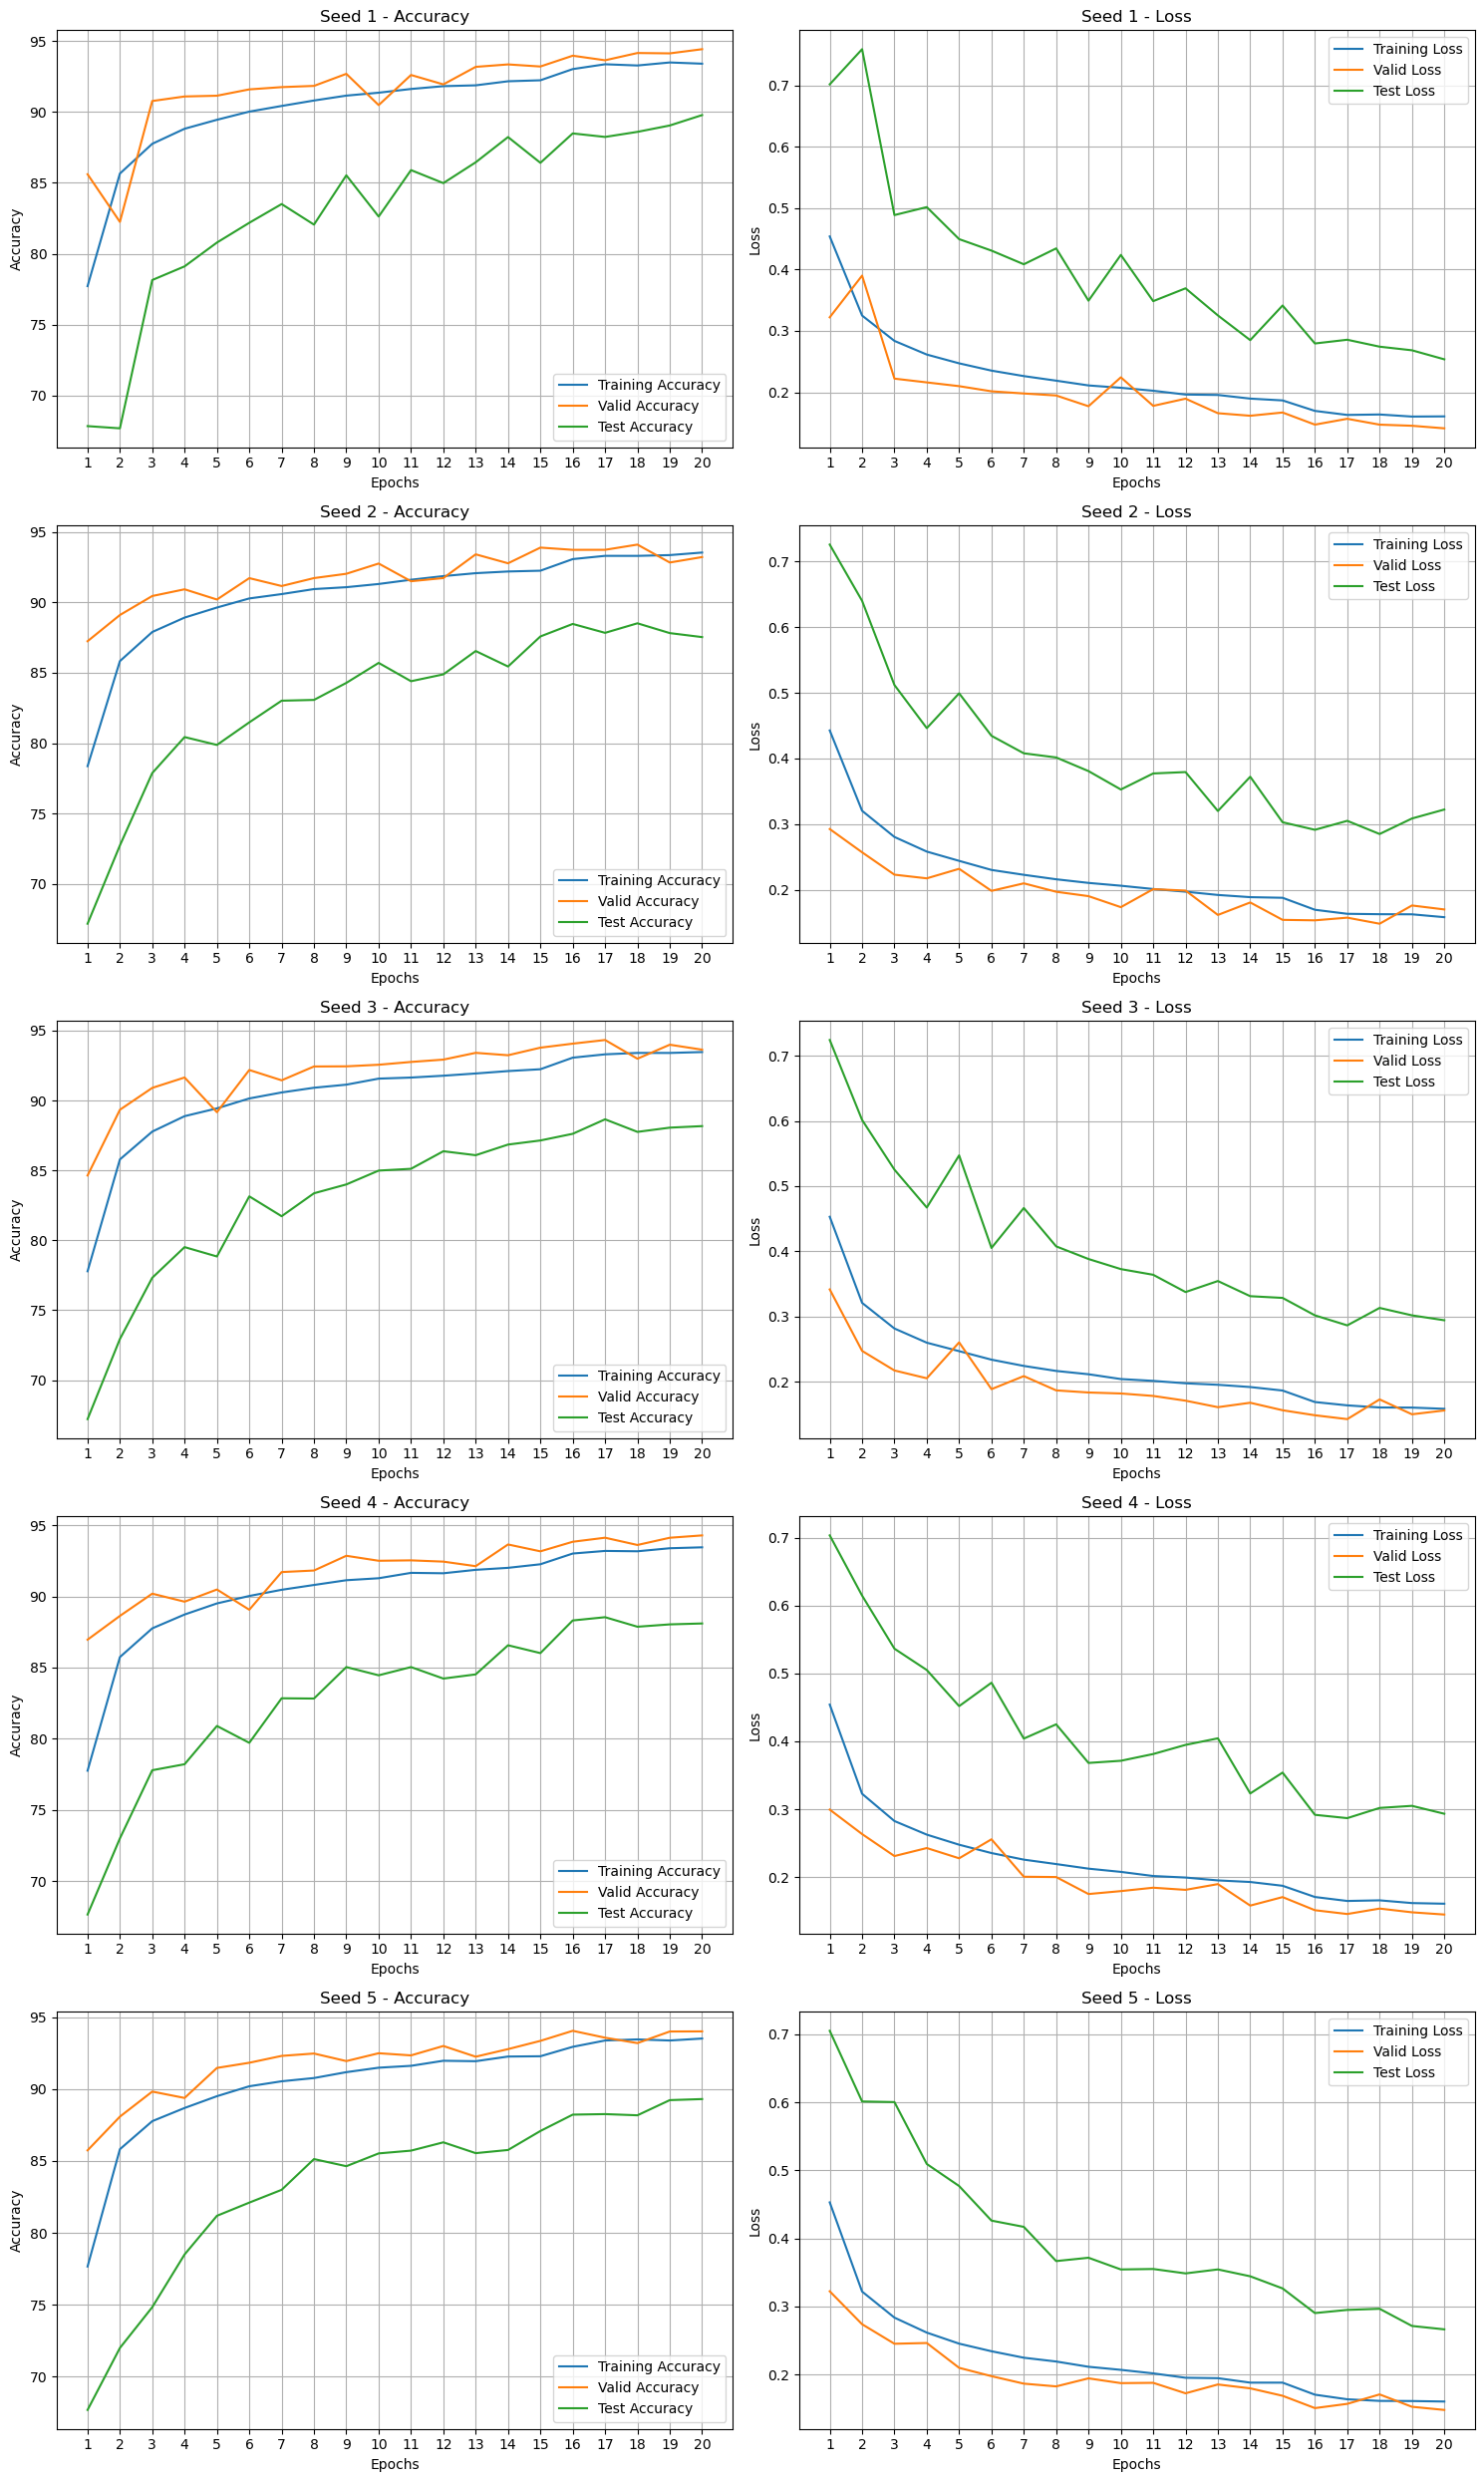

In [45]:
def plot_all_seeds_performance(global_train_accuracies, global_valid_accuracies, global_test_accuracies,
                               global_train_losses, global_valid_losses, global_test_losses):
    num_seeds = len(global_train_accuracies)
    epochs = range(1, 21)  # 20 epochs

    fig, axs = plt.subplots(num_seeds, 2, figsize=(15, 5 * num_seeds)) 

    for i in range(num_seeds):
        # Accuracy 
        ax1 = axs[i, 0]
        ax1.plot(epochs, global_train_accuracies[i], label='Training Accuracy')
        ax1.plot(epochs, global_valid_accuracies[i], label='Valid Accuracy')
        ax1.plot(epochs, global_test_accuracies[i], label='Test Accuracy')
        ax1.set_title(f'Seed {i+1} - Accuracy')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
        ax1.set_xticks(epochs)

        # Loss 
        ax2 = axs[i, 1]
        ax2.plot(epochs, global_train_losses[i], label='Training Loss')
        ax2.plot(epochs, global_valid_losses[i], label='Valid Loss')
        ax2.plot(epochs, global_test_losses[i], label='Test Loss')
        ax2.set_title(f'Seed {i+1} - Loss')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        ax2.set_xticks(epochs)

    plt.tight_layout()
    plt.show()

plot_all_seeds_performance(global_train_accuracies, global_valid_accuracies, global_test_accuracies,
                           global_train_losses, global_valid_losses, global_test_losses)

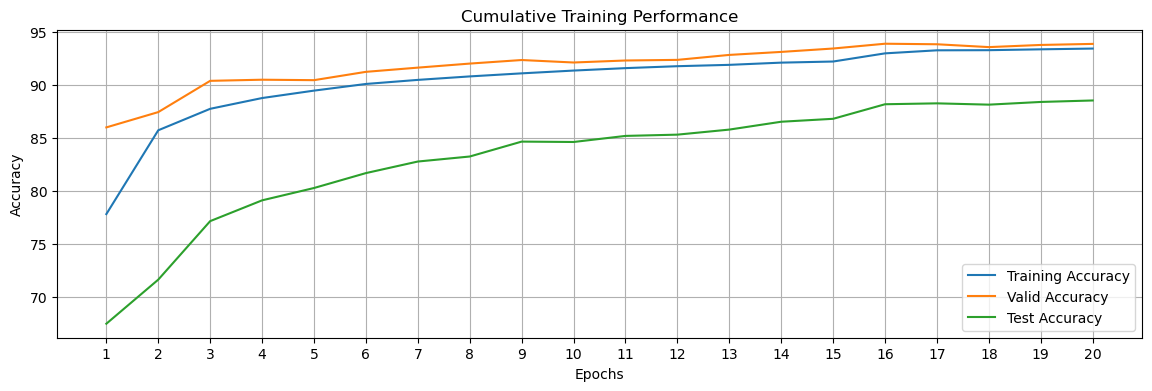

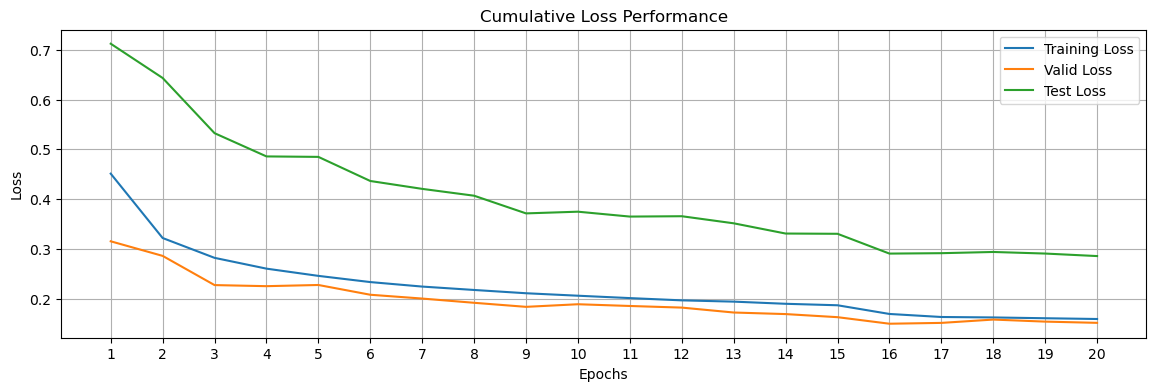

In [46]:
plot_accuracy_performance(cumulative_train_accuracies, cumulative_valid_accuracies, cumulative_test_accuracies, title='Cumulative Training Performance')
plot_loss_performance(cumulative_train_losses, cumulative_valid_losses, cumulative_test_losses, title='Cumulative Loss Performance')

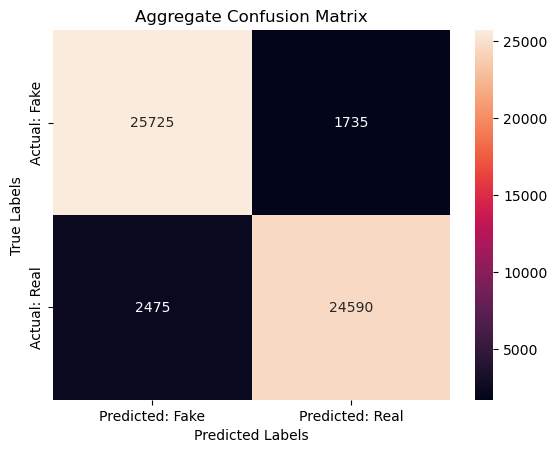

In [47]:
# Aggregate confusion matrices
aggregate_cm = np.zeros((2, 2), dtype=int)  
for predictions, labels in confusion_list:
    cm = confusion_matrix(labels, predictions)
    aggregate_cm += cm

def plot_confusion_matrix(cm):
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Predicted: Fake", "Predicted: Real"], yticklabels=["Actual: Fake", "Actual: Real"])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Aggregate Confusion Matrix')
    plt.show()

plot_confusion_matrix(aggregate_cm)

# Convert Data To numpy

We now convert the tensors to numpy arrays so that we can use them with sklearn and other libraries. There is also an included function that allows you to train on subsections of the dataset. Given the vast size of the dataset, this can be helpful for quick tests. To run without splitting the data, you can just modify the function to divide by 1.

In [16]:
def tensors_to_numpy(loader):
    images_np = []
    labels_np = []

    for images, labels in loader:
        batch_images = images.view(images.size(0), -1).numpy() 
        batch_labels = labels.numpy()

        images_np.append(batch_images)
        labels_np.append(batch_labels)

    images_np = np.concatenate(images_np, axis=0)
    labels_np = np.concatenate(labels_np, axis=0)

    return images_np, labels_np

def create_half_size_loader(dataset, batch_size=32, shuffle=True, num_workers=15):
    half_size = len(dataset) // 1
    indices = torch.randperm(len(dataset)).tolist()[:half_size]
    subset = Subset(dataset, indices)
    return DataLoader(subset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

train_loader_half = create_half_size_loader(train_dataset)
valid_loader_half = create_half_size_loader(validation_dataset)
test_loader_half = create_half_size_loader(test_dataset)

X_train_half, Y_train_half = tensors_to_numpy(train_loader_half)
X_valid_half, Y_valid_half = tensors_to_numpy(valid_loader_half)
X_test_half, Y_test_half = tensors_to_numpy(test_loader_half)

# SVMs

In [17]:
# Fit
svm_rbf = SVC(kernel='rbf', C=1, gamma=0.001)
svm_rbf.fit(X_train_half, Y_train_half)

rbf_predictions_train = svm_rbf.predict(X_train_half)
rbf_accuracy_train = accuracy_score(Y_train_half, rbf_predictions_train)

rbf_predictions_valid = svm_rbf.predict(X_valid_half)
rbf_accuracy_valid = accuracy_score(Y_valid_half, rbf_predictions_valid)

svm_poly = SVC(kernel='polynomial', degree=2, gamma=0.001, coef0=1)
svm_poly.fit(X_train_half, Y_train_half)

poly_predictions_train = svm_poly.predict(X_train_half)
poly_accuracy_train = accuracy_score(Y_train_half, poly_predictions_train)

poly_predictions_valid = svm_poly.predict(X_valid_half)
poly_accuracy_valid = accuracy_score(Y_valid_half, poly_predictions_valid)

print(f"RBF Train Accuracy: {rbf_accuracy_train}")
print(f"RBF Validation Accuracy: {rbf_accuracy_valid}")
print(f"Polynomial Train Accuracy: {poly_accuracy_train}")
print(f"Polynomial Validation Accuracy: {poly_accuracy_valid}")

RBF Train Accuracy: 0.7790174426079628
RBF Validation Accuracy: 0.7470832910621893
Polynomial Train Accuracy: 0.7770460421993971
Polynomial Validation Accuracy: 0.7424419194481079


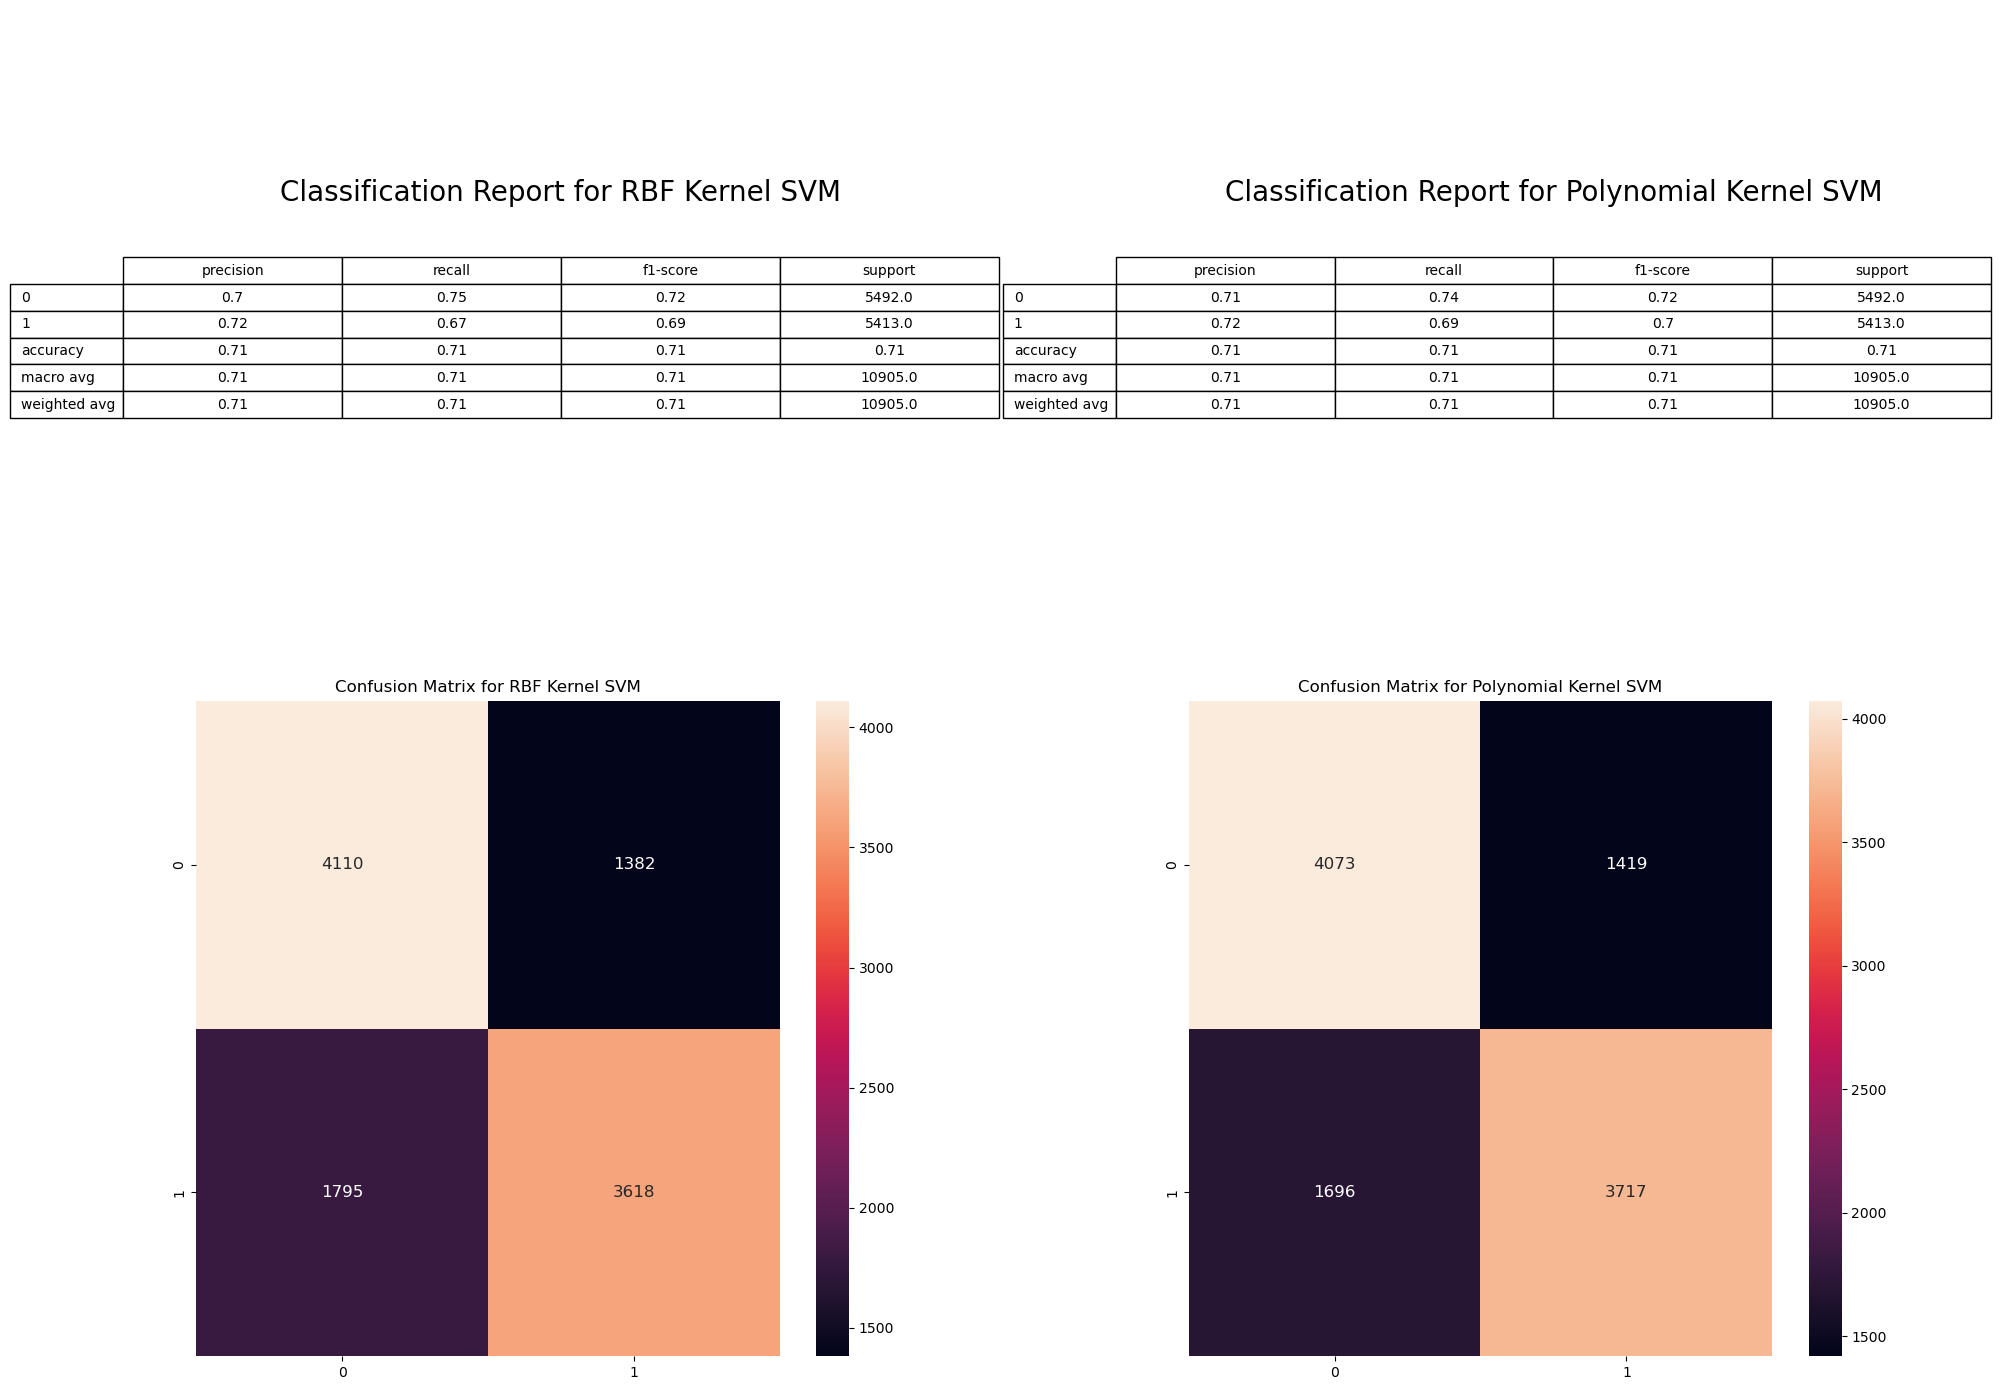

In [18]:
# Evaluation
rbf_predictions_test = svm_rbf.predict(X_test_half)
poly_predictions_test = svm_poly.predict(X_test_half)

report_rbf_df = pd.DataFrame(classification_report(Y_test_half, rbf_predictions_test, output_dict=True)).transpose().round(2)
report_poly_df = pd.DataFrame(classification_report(Y_test_half, poly_predictions_test, output_dict=True)).transpose().round(2)
cm_rbf = confusion_matrix(Y_test_half, rbf_predictions_test)
cm_poly = confusion_matrix(Y_test_half, poly_predictions_test)

fig, axes = plt.subplots(2, 2, figsize=(20, 14))  
plt.subplots_adjust(hspace=0.2, wspace=0.3)  

axes[0, 0].axis('off')
table_rbf = axes[0, 0].table(cellText=report_rbf_df.values, colLabels=report_rbf_df.columns, rowLabels=report_rbf_df.index, cellLoc='center', loc='center')
table_rbf.auto_set_font_size(False)
table_rbf.set_fontsize(10)
table_rbf.scale(1.2, 1.2)
axes[0, 0].text(0.5, 0.7, 'Classification Report for RBF Kernel SVM', fontsize=20, ha='center', va='bottom', transform=axes[0, 0].transAxes)

axes[0, 1].axis('off')
table_poly = axes[0, 1].table(cellText=report_poly_df.values, colLabels=report_poly_df.columns, rowLabels=report_poly_df.index, cellLoc='center', loc='center')
table_poly.auto_set_font_size(False)
table_poly.set_fontsize(10)
table_poly.scale(1.2, 1.2)
axes[0, 1].text(0.5, 0.7, 'Classification Report for Polynomial Kernel SVM', fontsize=20, ha='center', va='bottom', transform=axes[0, 1].transAxes)

sns.heatmap(cm_rbf, annot=True, fmt="d", ax=axes[1, 0], cbar=True, annot_kws={"size": 12})
axes[1, 0].set_title('Confusion Matrix for RBF Kernel SVM', fontsize=12)

sns.heatmap(cm_poly, annot=True, fmt="d", ax=axes[1, 1], cbar=True, annot_kws={"size": 12})
axes[1, 1].set_title('Confusion Matrix for Polynomial Kernel SVM', fontsize=12)

plt.tight_layout()
plt.show()

# Random Forest

In [19]:
# Fit
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=1, n_jobs=-1)
rf_classifier.fit(X_train_half, Y_train_half)

predictions = rf_classifier.predict(X_train_half)
accuracy = accuracy_score(Y_train_half, predictions)
print(f'Train Accuracy: {accuracy}')

predictions = rf_classifier.predict(X_valid_half)
accuracy = accuracy_score(Y_valid_half, predictions)
print(f'Validation Accuracy: {accuracy}')

Train Accuracy: 0.7630390994414366
Validation Accuracy: 0.7300395657908085


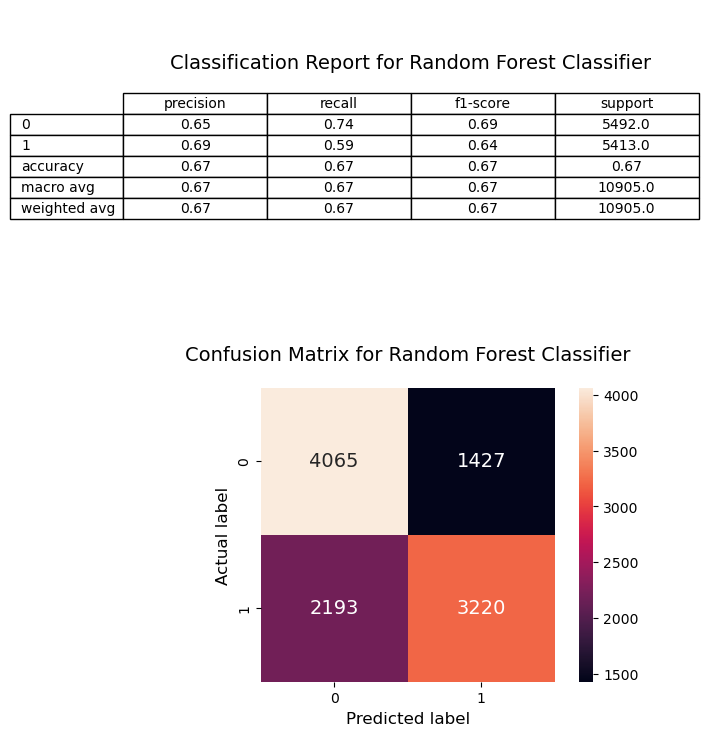

In [20]:
# Evaluation
predictions = rf_classifier.predict(X_test_half)
report_rf_df = pd.DataFrame(classification_report(Y_test_half, predictions, output_dict=True)).transpose().round(2)
cm_rf = confusion_matrix(Y_test_half, predictions)

fig = plt.figure(figsize=(8, 8))

ax_table = fig.add_subplot(211) 
ax_table.axis('off')  

ax_table.text(0.5, 0.8, 'Classification Report for Random Forest Classifier', fontsize=14, ha='center', transform=ax_table.transAxes)

table = ax_table.table(cellText=report_rf_df.values, colLabels=report_rf_df.columns, rowLabels=report_rf_df.index, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  

ax_cm = fig.add_subplot(212)  
sns.heatmap(cm_rf, annot=True, fmt="d", ax=ax_cm, cbar=True, annot_kws={"size": 14}, square=True)
ax_cm.set_title('Confusion Matrix for Random Forest Classifier', fontsize=14, pad=20)
ax_cm.set_ylabel('Actual label', fontsize=12)
ax_cm.set_xlabel('Predicted label', fontsize=12)

plt.tight_layout(pad=3.0)
plt.show()

# Decision Trees

In [21]:
# Fit
clf = tree.DecisionTreeClassifier(max_depth=5, random_state=1)
clf.fit(X_train_half, Y_train_half)

predictions_train = clf.predict(X_train_half)
accuracy_train = accuracy_score(Y_train_half, predictions_train)
print(f'Train Accuracy: {accuracy_train}')

predictions_valid = clf.predict(X_valid_half)
accuracy_valid = accuracy_score(Y_valid_half, predictions_valid)
print(f'Validation Accuracy: {accuracy_valid}')

Train Accuracy: 0.7095112926958186
Validation Accuracy: 0.6979050421020595


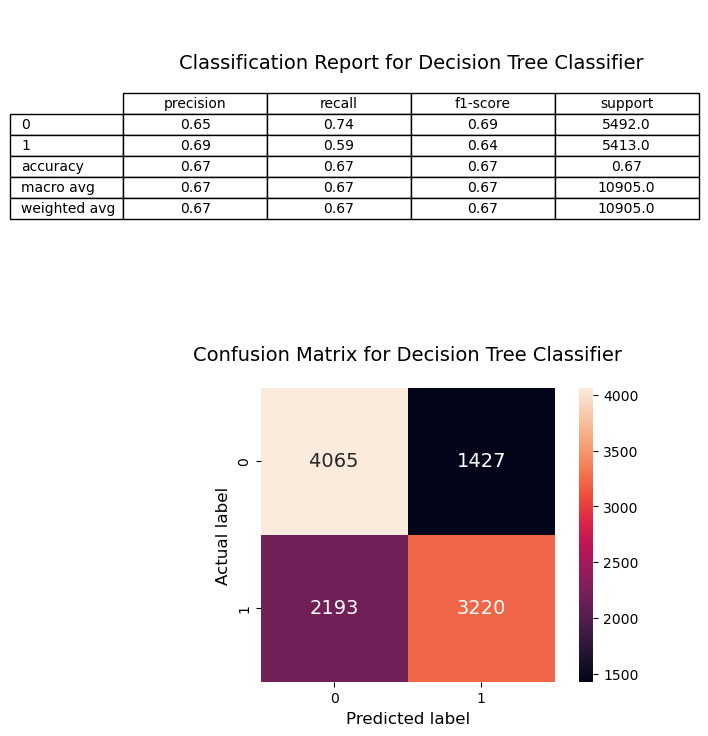

In [22]:
# Evaluation
predictions_test = clf.predict(X_test_half)
accuracy_test = accuracy_score(Y_test_half, predictions_test)
report_test = classification_report(Y_test_half, predictions_test, output_dict=True)
report_dt_df = pd.DataFrame(classification_report(Y_test_half, predictions, output_dict=True)).transpose().round(2)
cm_dt = confusion_matrix(Y_test_half, predictions)

fig = plt.figure(figsize=(8, 8))

ax_table = fig.add_subplot(211) 
ax_table.axis('off')  

ax_table.text(0.5, 0.8, 'Classification Report for Decision Tree Classifier', fontsize=14, ha='center', transform=ax_table.transAxes)

table = ax_table.table(cellText=report_dt_df.values, colLabels=report_dt_df.columns, rowLabels=report_dt_df.index, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2) 

ax_cm = fig.add_subplot(212) 
sns.heatmap(cm_dt, annot=True, fmt="d", ax=ax_cm, cbar=True, annot_kws={"size": 14}, square=True)
ax_cm.set_title('Confusion Matrix for Decision Tree Classifier', fontsize=14, pad=20)
ax_cm.set_ylabel('Actual label', fontsize=12)
ax_cm.set_xlabel('Predicted label', fontsize=12)

plt.tight_layout(pad=3.0)
plt.show()

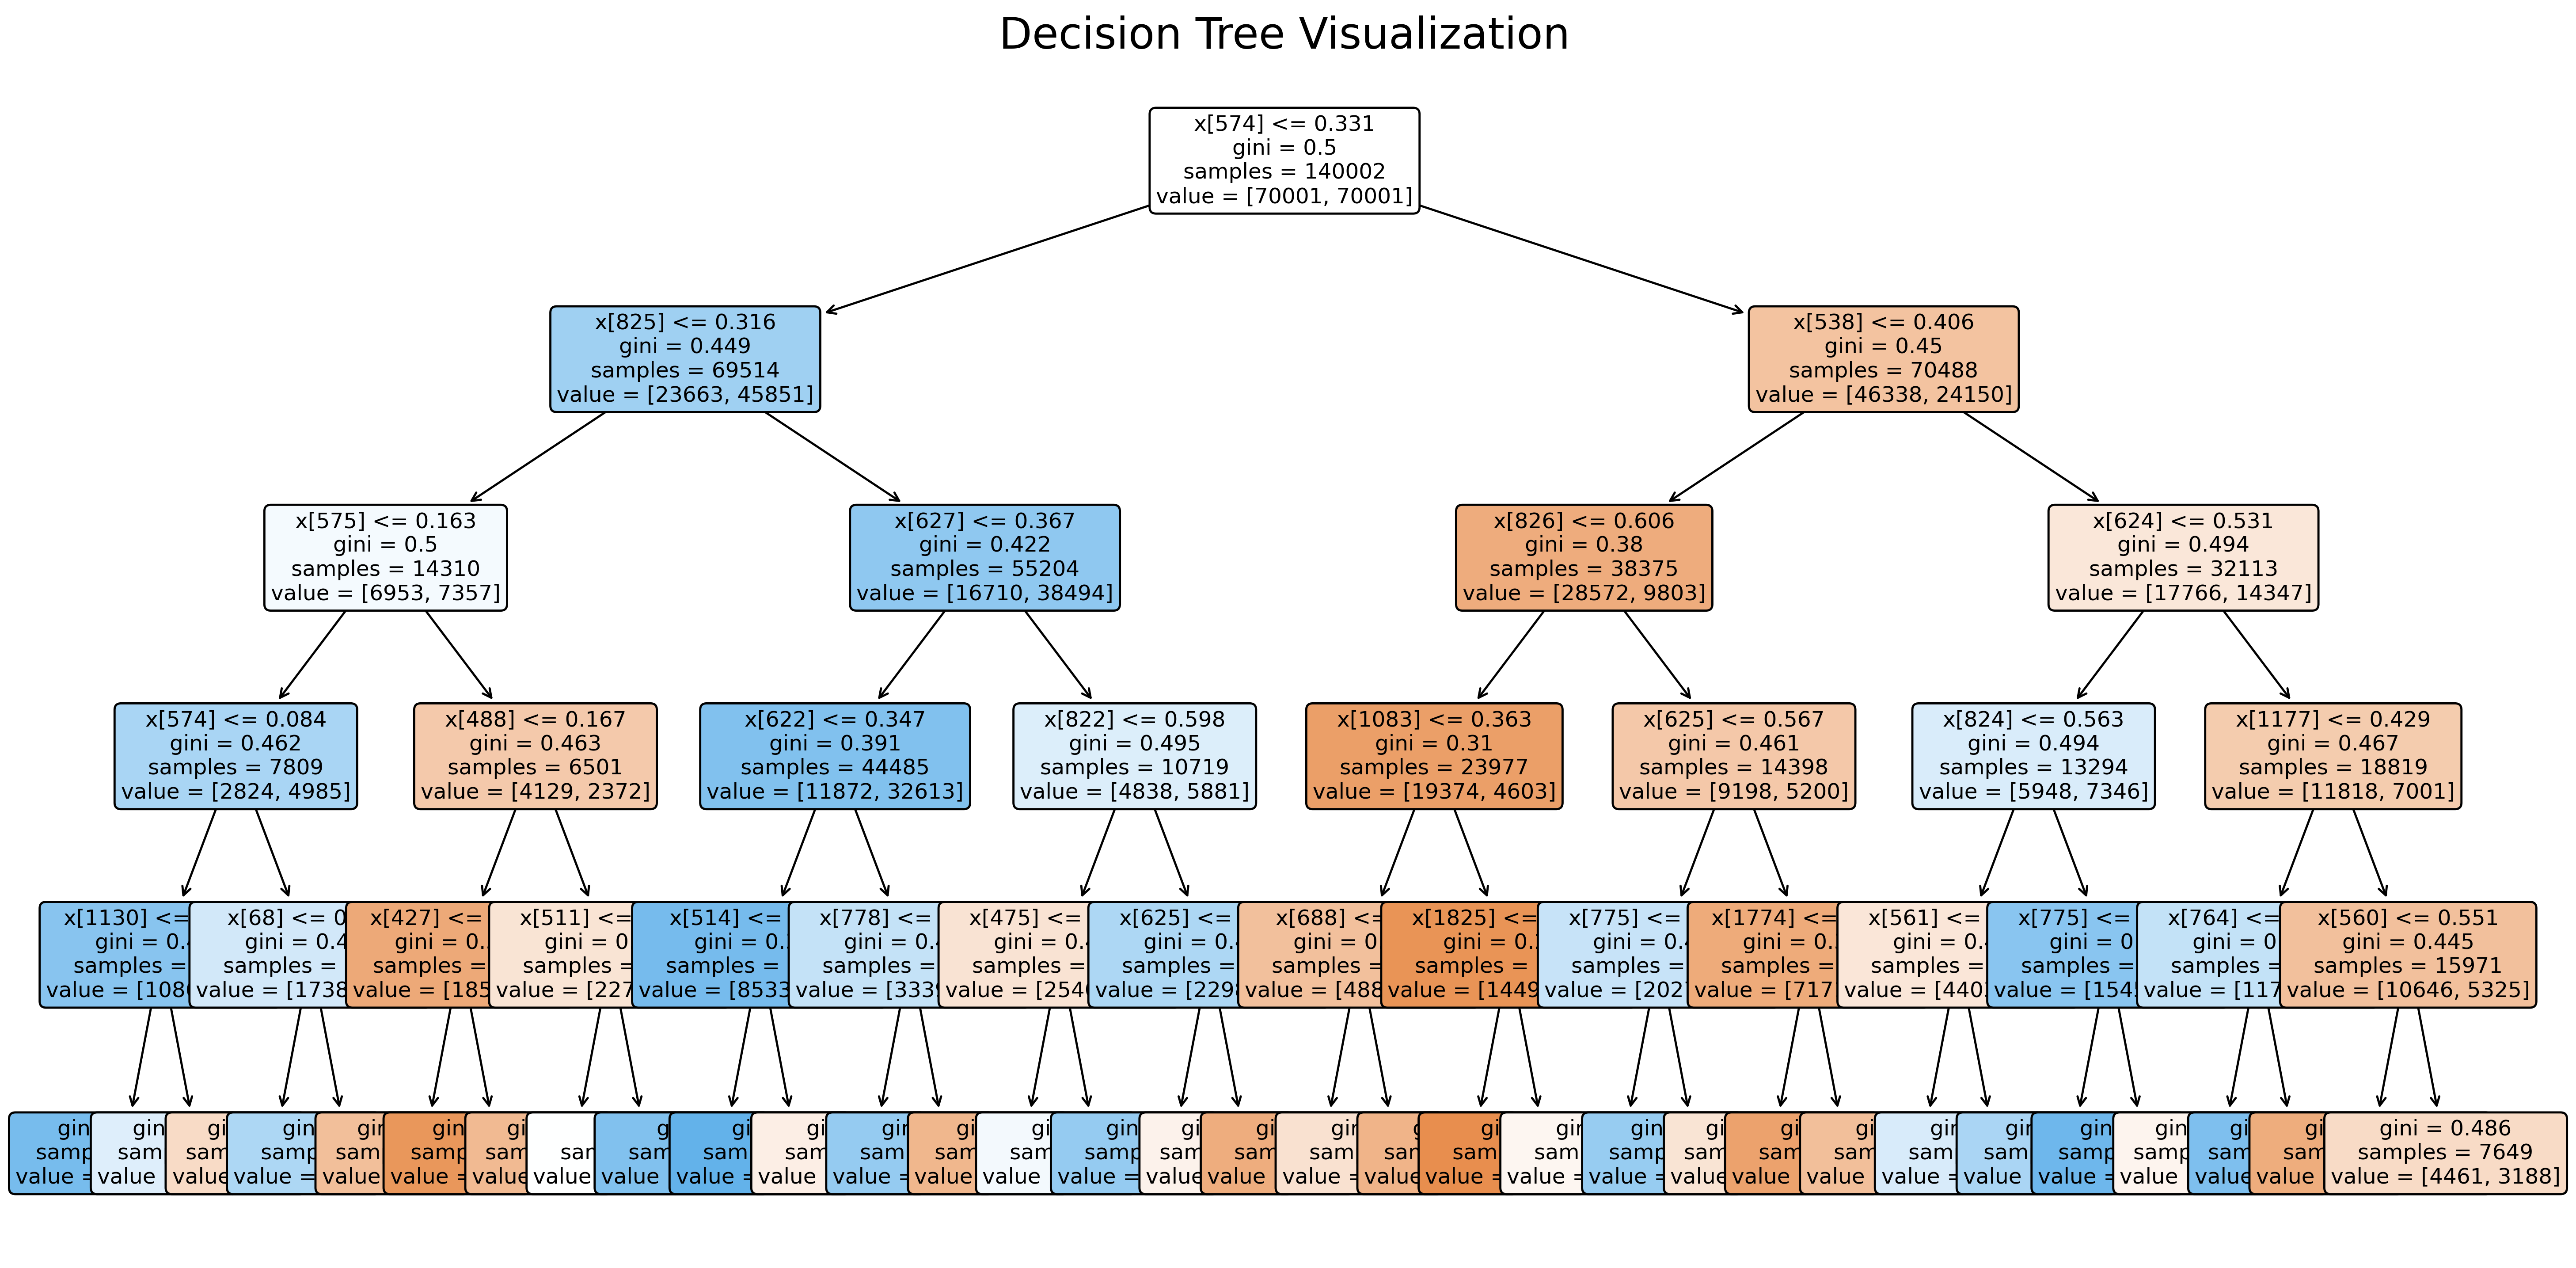

In [23]:
plt.figure(figsize=(20, 10), dpi=350) 
tree.plot_tree(clf, 
               filled=True, 
               rounded=True, 
               fontsize=10)   
plt.title('Decision Tree Visualization', fontsize=20)
plt.show()

# Logistic Classification

In [48]:
#Scale
scaler = StandardScaler()
X_train_half_scaled = scaler.fit_transform(X_train_half)
X_valid_half_scaled = scaler.fit_transform(X_valid_half)
X_test_half_scaled = scaler.transform(X_test_half)

# Fit
logistic_model = LogisticRegression(max_iter=20, C=1.0, n_jobs=-1, random_state=1)
logistic_model.fit(X_train_half_scaled, Y_train_half)

predictions_train = logistic_model.predict(X_train_half_scaled)
accuracy_train = accuracy_score(Y_train_half, predictions_train)
print(f'Train Accuracy: {accuracy_train}')

predictions_valid = logistic_model.predict(X_valid_half_scaled)
accuracy_valid = accuracy_score(Y_valid_half, predictions_valid)
print(f'Validation Accuracy: {accuracy_valid}')

Train Accuracy: 0.7520463993371523
Validation Accuracy: 0.7286699807243583


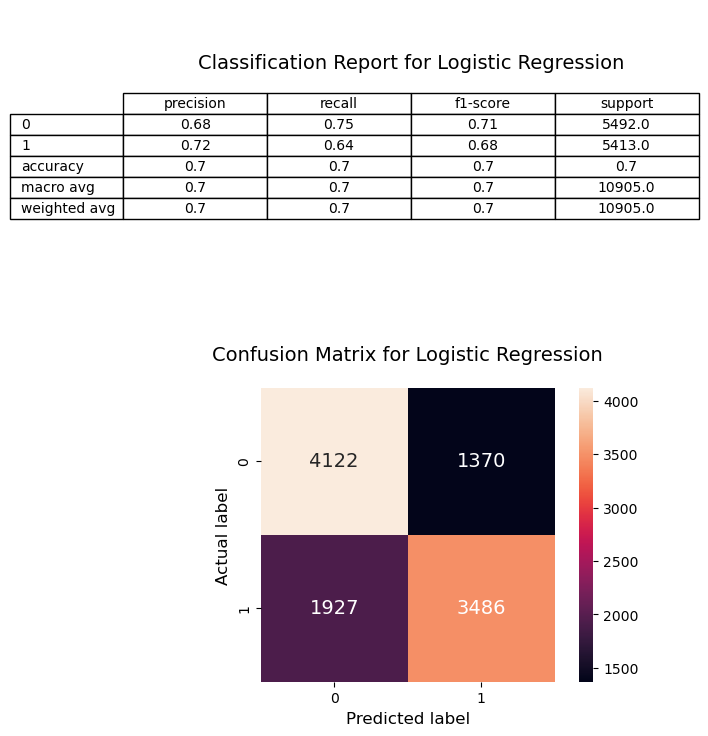

In [25]:
# Evaluation
predictions_test = logistic_model.predict(X_test_half_scaled)
accuracy_test = accuracy_score(Y_test_half, predictions_test)
report_test = classification_report(Y_test_half, predictions_test, output_dict=True)
report_lr_df = pd.DataFrame(report_test).transpose().round(2)
cm_lr = confusion_matrix(Y_test_half, predictions_test)

fig = plt.figure(figsize=(8, 8))

ax_table = fig.add_subplot(211)  
ax_table.axis('off')  

ax_table.text(0.5, 0.8, 'Classification Report for Logistic Regression', fontsize=14, ha='center', transform=ax_table.transAxes)

table = ax_table.table(cellText=report_lr_df.values, colLabels=report_lr_df.columns, rowLabels=report_lr_df.index, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  

ax_cm = fig.add_subplot(212)  
sns.heatmap(cm_lr, annot=True, fmt="d", ax=ax_cm, cbar=True, annot_kws={"size": 14}, square=True)
ax_cm.set_title('Confusion Matrix for Logistic Regression', fontsize=14, pad=20)
ax_cm.set_ylabel('Actual label', fontsize=12)
ax_cm.set_xlabel('Predicted label', fontsize=12)

plt.tight_layout(pad=3.0)
plt.show()